In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telecom-data/telecom_data_full.csv


In [19]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("LoadDataset").getOrCreate()

# Load dataset (replace 'data.csv' with your actual file path)
df = spark.read.csv("/kaggle/input/telecom-data/telecom_data_full.csv", header=True, inferSchema=True)

# Show few rows of the dataset
df.show(5)

+-----------+------+--------------+-------+----------+---------------+-------------+--------------+----------------+-------------------+-------------------+-------------------+-------------------+------------+----------------+--------------+-----------------+--------------+---------------+-------------+-----+
|Customer ID|Gender|Senior Citizen|Partner|Dependents|Tenure (months)|Phone Service|Multiple Lines|Internet Service|    Online Security|      Online Backup|  Device Protection|       Tech Support|Streaming TV|Streaming Movies| Contract Type|Paperless Billing|Payment Method|Monthly Charges|Total Charges|Churn|
+-----------+------+--------------+-------+----------+---------------+-------------+--------------+----------------+-------------------+-------------------+-------------------+-------------------+------------+----------------+--------------+-----------------+--------------+---------------+-------------+-----+
|  CUST00001|Female|             0|     No|       Yes|             

In [22]:

# Extract column names
column_names = df.columns
print("Column Names:", column_names)


Column Names: ['Customer ID', 'Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure (months)', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract Type', 'Paperless Billing', 'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn']


In [27]:
# Check schema (data types of columns)
df.printSchema()

root
 |-- Customer ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Senior Citizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Tenure (months): integer (nullable = true)
 |-- Phone Service: string (nullable = true)
 |-- Multiple Lines: string (nullable = true)
 |-- Internet Service: string (nullable = true)
 |-- Online Security: string (nullable = true)
 |-- Online Backup: string (nullable = true)
 |-- Device Protection: string (nullable = true)
 |-- Tech Support: string (nullable = true)
 |-- Streaming TV: string (nullable = true)
 |-- Streaming Movies: string (nullable = true)
 |-- Contract Type: string (nullable = true)
 |-- Paperless Billing: string (nullable = true)
 |-- Payment Method: string (nullable = true)
 |-- Monthly Charges: double (nullable = true)
 |-- Total Charges: double (nullable = true)
 |-- Churn: string (nullable = true)



In [28]:
# Show summary statistics
df.describe().show()

+-------+-----------+------+------------------+-------+----------+------------------+-------------+--------------+----------------+---------------+-------------+-----------------+------------+------------+----------------+--------------+-----------------+--------------+-----------------+------------------+-----+
|summary|Customer ID|Gender|    Senior Citizen|Partner|Dependents|   Tenure (months)|Phone Service|Multiple Lines|Internet Service|Online Security|Online Backup|Device Protection|Tech Support|Streaming TV|Streaming Movies| Contract Type|Paperless Billing|Payment Method|  Monthly Charges|     Total Charges|Churn|
+-------+-----------+------+------------------+-------+----------+------------------+-------------+--------------+----------------+---------------+-------------+-----------------+------------+------------+----------------+--------------+-----------------+--------------+-----------------+------------------+-----+
|  count|      10000| 10000|             10000|  10000|   

In [29]:
# Check for missing values
from pyspark.sql.functions import col, sum

missing_values = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_values.show()


+-----------+------+--------------+-------+----------+---------------+-------------+--------------+----------------+---------------+-------------+-----------------+------------+------------+----------------+-------------+-----------------+--------------+---------------+-------------+-----+
|Customer ID|Gender|Senior Citizen|Partner|Dependents|Tenure (months)|Phone Service|Multiple Lines|Internet Service|Online Security|Online Backup|Device Protection|Tech Support|Streaming TV|Streaming Movies|Contract Type|Paperless Billing|Payment Method|Monthly Charges|Total Charges|Churn|
+-----------+------+--------------+-------+----------+---------------+-------------+--------------+----------------+---------------+-------------+-----------------+------------+------------+----------------+-------------+-----------------+--------------+---------------+-------------+-----+
|          0|     0|             0|      0|         0|              0|            0|             0|               0|           

In [30]:
# Drop rows with any missing values (optional)
df = df.dropna()

# Fill missing values (example: replace numerical columns with mean)
from pyspark.sql.functions import mean

numeric_cols = [c for c, t in df.dtypes if t in ['int', 'double']]
impute_values = df.select([mean(col(c)).alias(c) for c in numeric_cols]).collect()[0].asDict()
df = df.fillna(impute_values)


In [31]:
from pyspark.ml.feature import StringIndexer

categorical_cols = [c for c, t in df.dtypes if t == 'string']
indexers = [StringIndexer(inputCol=c, outputCol=c + "_index").fit(df) for c in categorical_cols]

from pyspark.ml import Pipeline
pipeline = Pipeline(stages=indexers)
df = pipeline.fit(df).transform(df)


In [32]:
from pyspark.ml.feature import StandardScaler, VectorAssembler

assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

pipeline = Pipeline(stages=[assembler, scaler])
df = pipeline.fit(df).transform(df)


In [38]:
from pyspark.sql.functions import col

categorical_cols = ["Gender", "Senior Citizen", "Partner", "Dependents", "Phone Service",
                    "Multiple Lines", "Internet Service", "Online Security", "Online Backup", 
                    "Device Protection", "Tech Support", "Streaming TV", "Streaming Movies",
                    "Contract Type", "Paperless Billing", "Payment Method", "Churn"]

for col_name in categorical_cols:
    df.groupBy(col_name).count().show()


+------+-----+
|Gender|count|
+------+-----+
|Female| 4983|
|  Male| 5017|
+------+-----+

+--------------+-----+
|Senior Citizen|count|
+--------------+-----+
|             1| 1515|
|             0| 8485|
+--------------+-----+

+-------+-----+
|Partner|count|
+-------+-----+
|     No| 5077|
|    Yes| 4923|
+-------+-----+

+----------+-----+
|Dependents|count|
+----------+-----+
|        No| 4920|
|       Yes| 5080|
+----------+-----+

+-------------+-----+
|Phone Service|count|
+-------------+-----+
|           No|  996|
|          Yes| 9004|
+-------------+-----+

+----------------+-----+
|  Multiple Lines|count|
+----------------+-----+
|No phone service| 3274|
|              No| 3369|
|             Yes| 3357|
+----------------+-----+

+----------------+-----+
|Internet Service|count|
+----------------+-----+
|     Fiber optic| 4433|
|              No| 1514|
|             DSL| 4053|
+----------------+-----+

+-------------------+-----+
|    Online Security|count|
+----------------

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas
df_pd = df.toPandas()


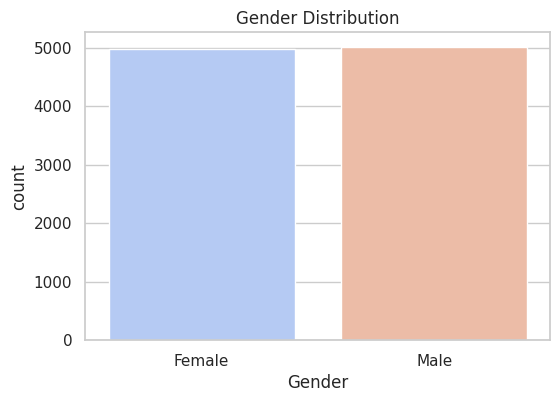

In [40]:
# Set style
sns.set(style="whitegrid")

# Plot Gender Distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df_pd, x="Gender", palette="coolwarm")
plt.title("Gender Distribution")
plt.show()


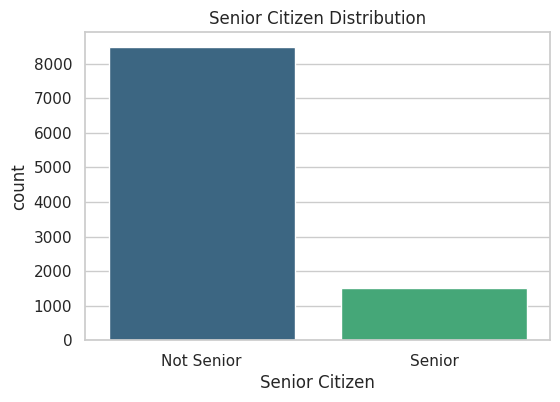

In [41]:
# Senior Citizen Distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df_pd, x="Senior Citizen", palette="viridis")
plt.title("Senior Citizen Distribution")
plt.xticks(ticks=[0, 1], labels=["Not Senior", "Senior"])
plt.show()


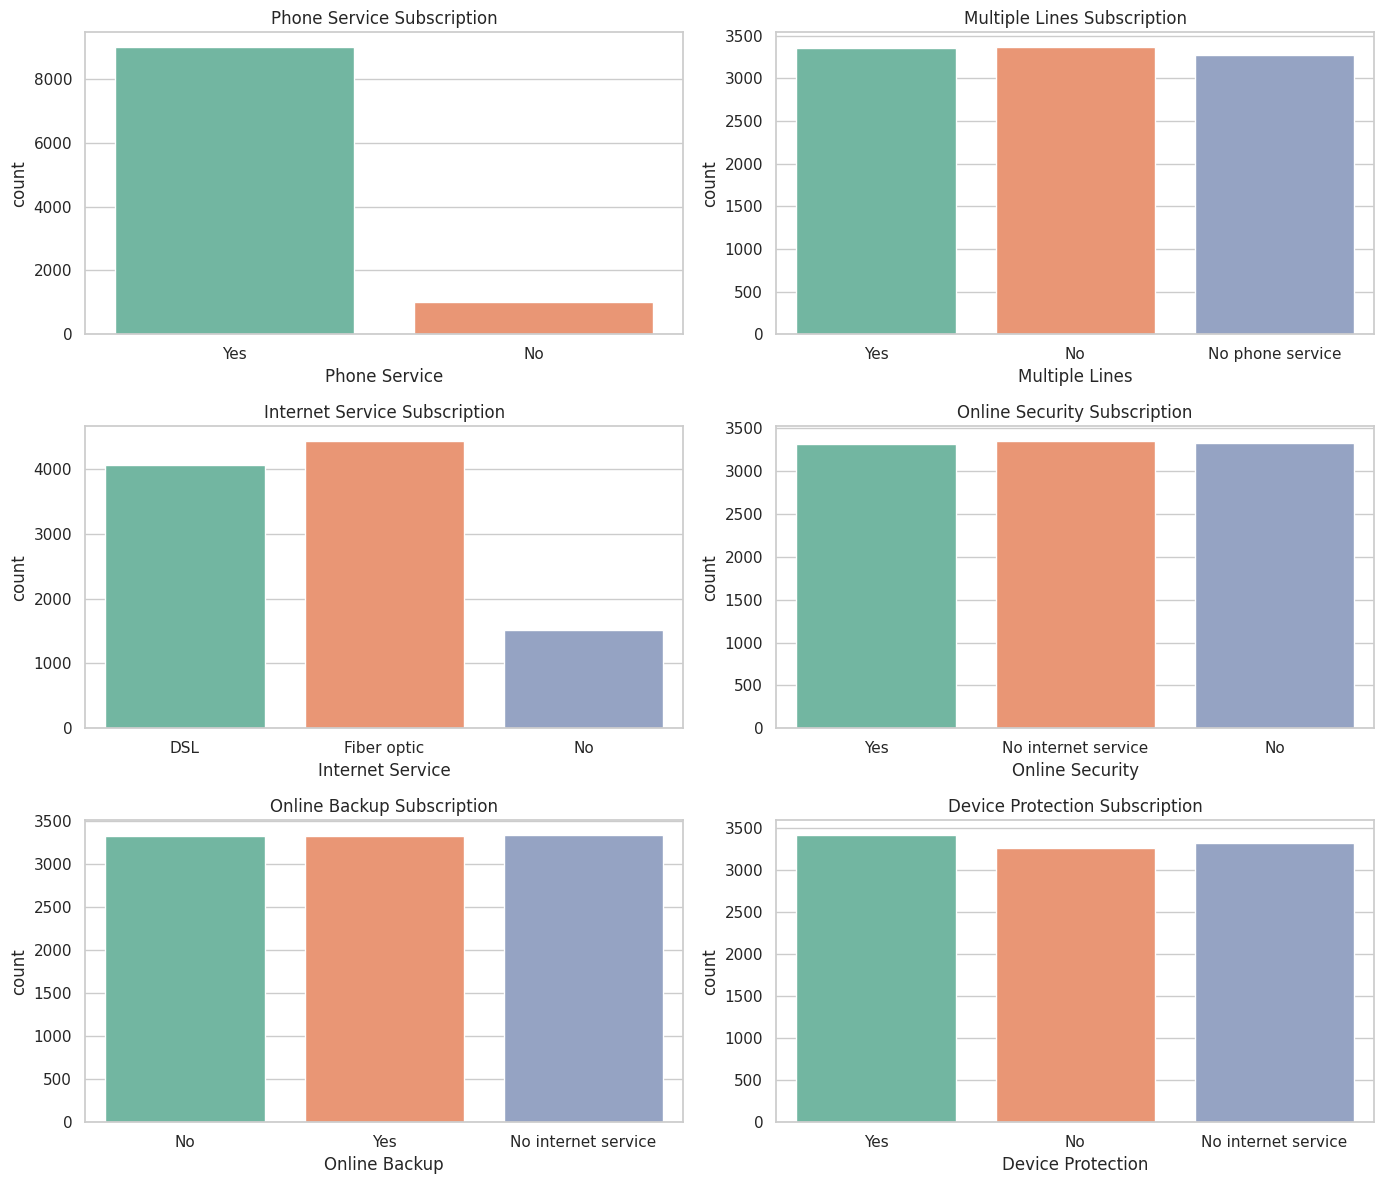

In [42]:
service_cols = ["Phone Service", "Multiple Lines", "Internet Service",
                "Online Security", "Online Backup", "Device Protection"]

fig, axes = plt.subplots(3, 2, figsize=(14, 12))

for i, col_name in enumerate(service_cols):
    row, col = divmod(i, 2)
    sns.countplot(data=df_pd, x=col_name, palette="Set2", ax=axes[row, col])
    axes[row, col].set_title(f"{col_name} Subscription")

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


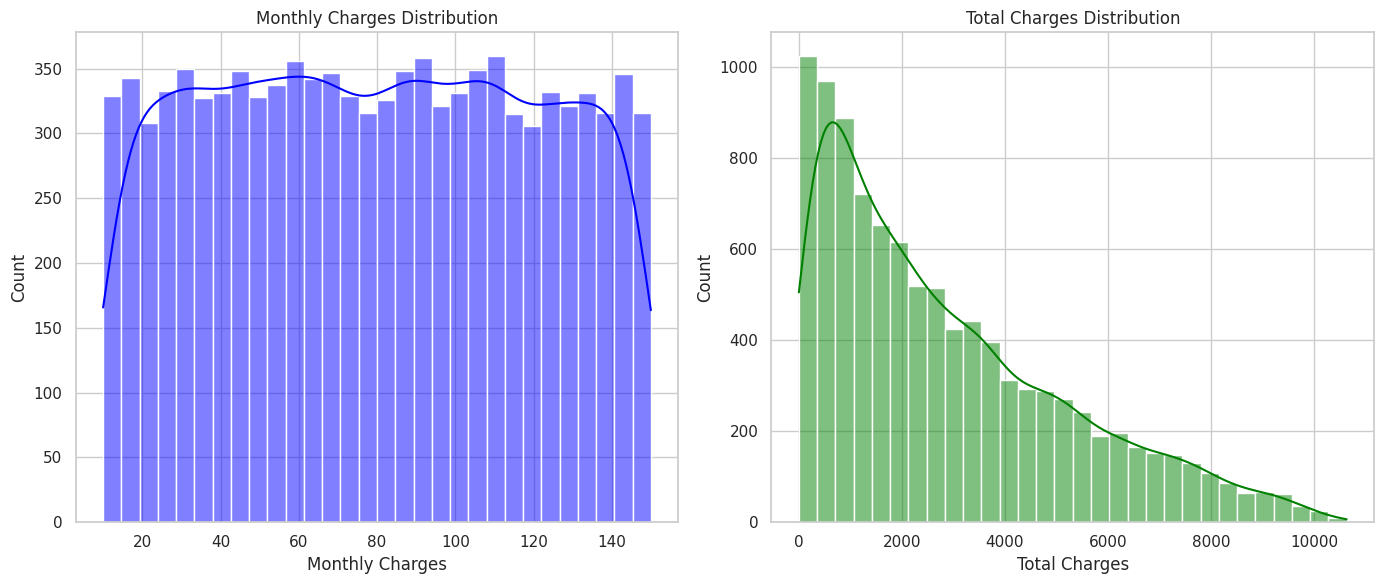

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Monthly Charges Distribution
sns.histplot(df_pd["Monthly Charges"], bins=30, kde=True, color="blue", ax=axes[0])
axes[0].set_title("Monthly Charges Distribution")

# Total Charges Distribution
sns.histplot(df_pd["Total Charges"], bins=30, kde=True, color="green", ax=axes[1])
axes[1].set_title("Total Charges Distribution")

plt.tight_layout()
plt.show()


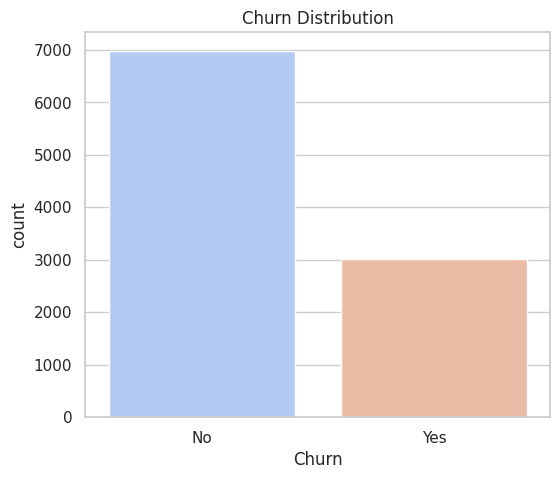

In [44]:
# Churn Distribution
plt.figure(figsize=(6, 5))
sns.countplot(data=df_pd, x="Churn", palette="coolwarm")
plt.title("Churn Distribution")
plt.show()


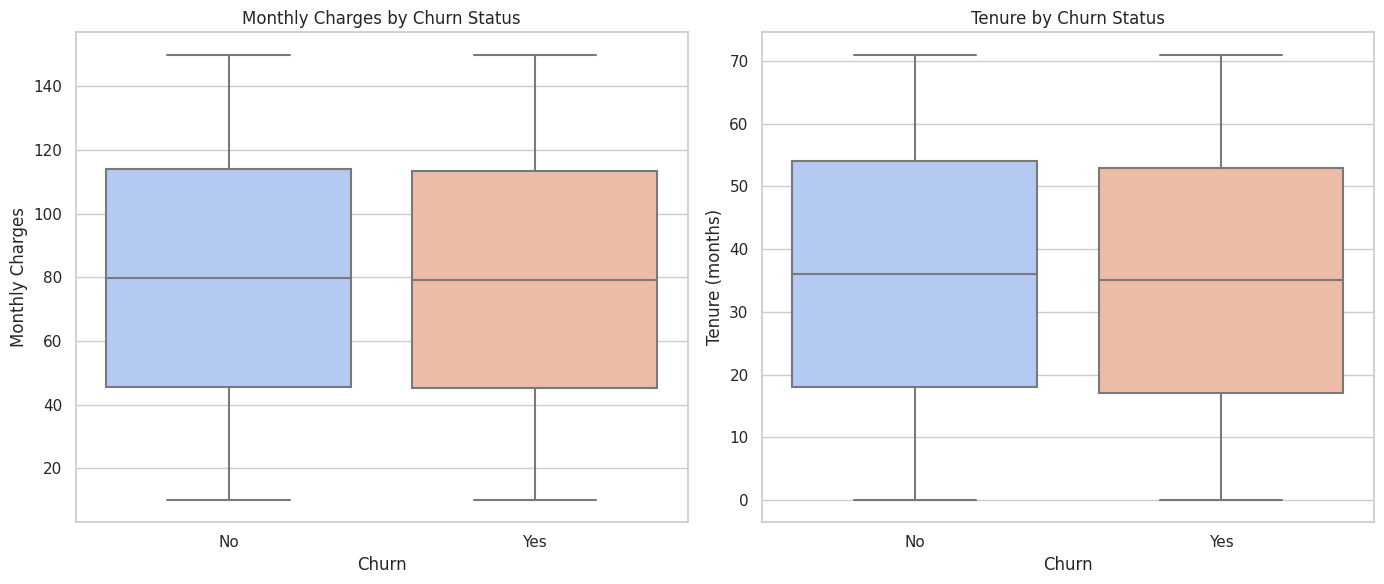

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(data=df_pd, x="Churn", y="Monthly Charges", palette="coolwarm", ax=axes[0])
axes[0].set_title("Monthly Charges by Churn Status")

sns.boxplot(data=df_pd, x="Churn", y="Tenure (months)", palette="coolwarm", ax=axes[1])
axes[1].set_title("Tenure by Churn Status")

plt.tight_layout()
plt.show()


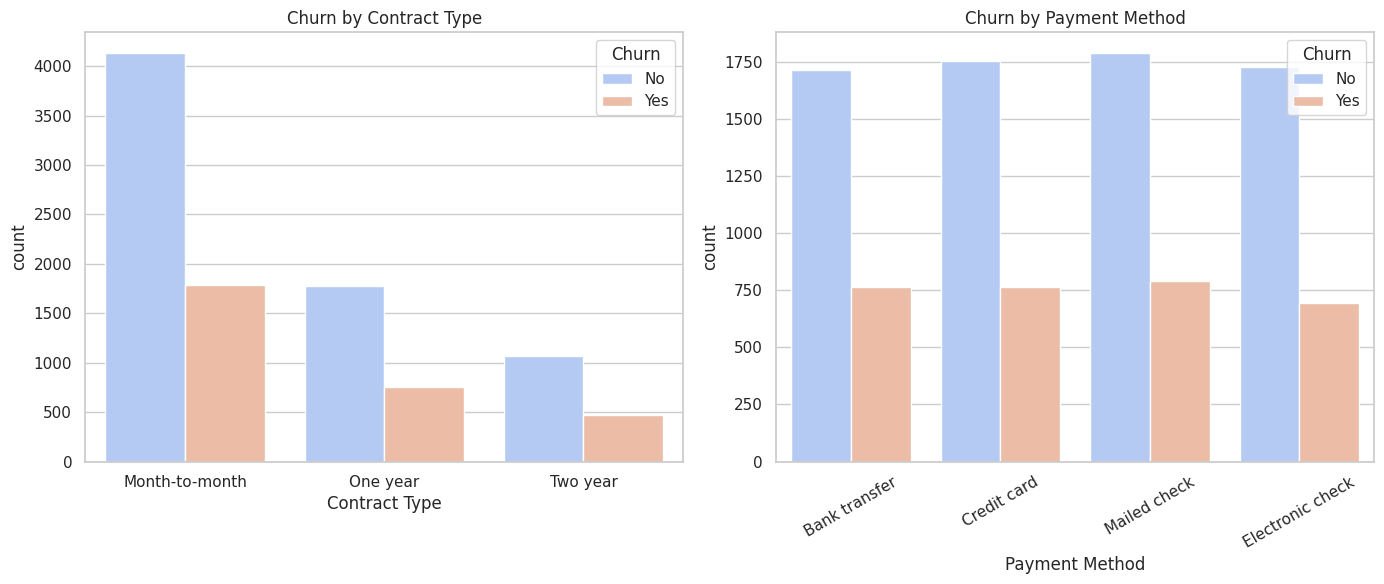

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(data=df_pd, x="Contract Type", hue="Churn", palette="coolwarm", ax=axes[0])
axes[0].set_title("Churn by Contract Type")

sns.countplot(data=df_pd, x="Payment Method", hue="Churn", palette="coolwarm", ax=axes[1])
axes[1].set_title("Churn by Payment Method")
plt.xticks(rotation=30)

plt.tight_layout()
plt.show()


Majority count: 6989
Minority count after upsampling: 6989

Random Forest Accuracy: 0.8951
Confusion Matrix for Random Forest:
[[1248   87]
 [ 197 1176]]
F1 Score for Random Forest: 0.8923
Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       0.86      0.93      0.90      1335
         1.0       0.93      0.86      0.89      1373

    accuracy                           0.90      2708
   macro avg       0.90      0.90      0.90      2708
weighted avg       0.90      0.90      0.90      2708


Logistic Regression Accuracy: 0.5199
Confusion Matrix for Logistic Regression:
[[757 578]
 [722 651]]
F1 Score for Logistic Regression: 0.5004
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.51      0.57      0.54      1335
         1.0       0.53      0.47      0.50      1373

    accuracy                           0.52      2708
   macro avg       0.52      0.52 

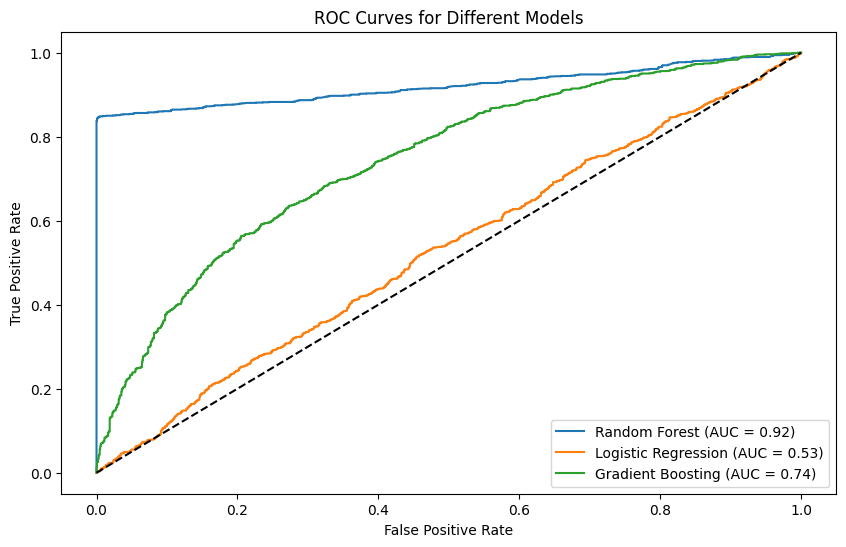

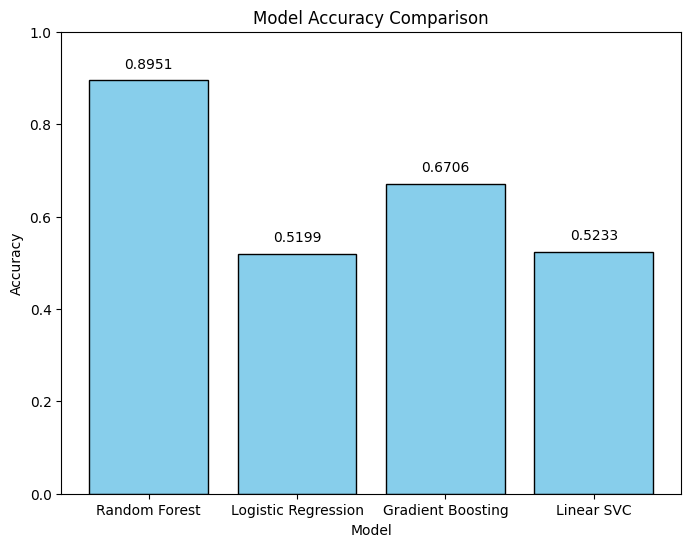


=== Detailed Analysis Summary ===

Model: Random Forest
Accuracy: 0.8951
F1 Score: 0.8923
Confusion Matrix:
[[1248   87]
 [ 197 1176]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.93      0.90      1335
         1.0       0.93      0.86      0.89      1373

    accuracy                           0.90      2708
   macro avg       0.90      0.90      0.90      2708
weighted avg       0.90      0.90      0.90      2708

Insight: This model is performing strongly, with balanced precision and recall.

Model: Logistic Regression
Accuracy: 0.5199
F1 Score: 0.5004
Confusion Matrix:
[[757 578]
 [722 651]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.51      0.57      0.54      1335
         1.0       0.53      0.47      0.50      1373

    accuracy                           0.52      2708
   macro avg       0.52      0.52      0.52      2708
weighted avg       0.52      0.52   

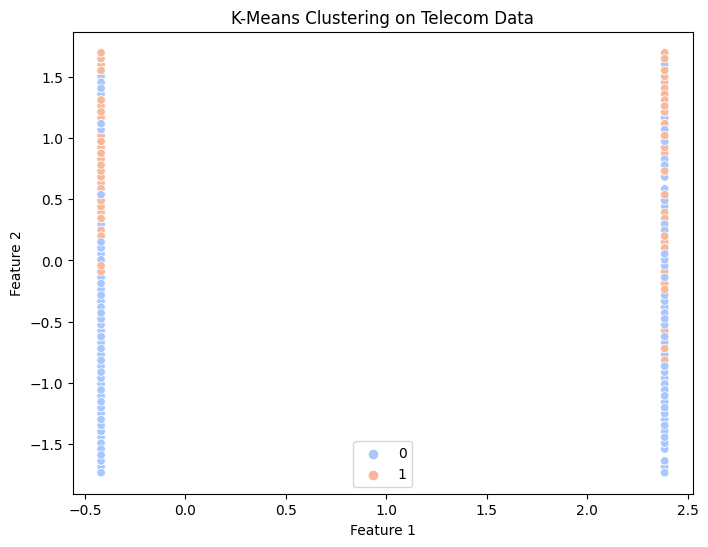


KNN Model Accuracy (evaluated locally): 0.6337


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.sql.types import StringType

from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier, LinearSVC
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

import matplotlib.pyplot as plt
import seaborn as sns

# Additional imports for metrics
from sklearn.metrics import confusion_matrix, f1_score, classification_report, roc_curve, auc

import numpy as np

# Initialize Spark session
spark = SparkSession.builder.appName("TelecomChurnSpark").getOrCreate()

# -------------------------
# Data Loading & Preprocessing
# -------------------------
file_path = "/kaggle/input/telecom-data/telecom_data_full.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Drop irrelevant column and create numeric label for "Churn"
df = df.drop("Customer ID")
df = df.withColumn("label", when(col("Churn") == "Yes", 1.0).otherwise(0.0))

# Identify categorical columns (excluding the target "Churn")
categorical_cols = [f.name for f in df.schema.fields 
                    if isinstance(f.dataType, StringType) and f.name not in ["Churn"]]

# Create indexers for categorical columns
indexers = [StringIndexer(inputCol=col_name, outputCol=col_name + "_indexed", handleInvalid="keep")
            for col_name in categorical_cols]

# Identify numeric columns (exclude the label column)
numeric_cols = [f.name for f in df.schema.fields 
                if not isinstance(f.dataType, StringType) and f.name not in ["label"]]

# The features will be the numeric columns plus the indexed categorical columns
assembler_inputs = numeric_cols + [c + "_indexed" for c in categorical_cols]

# Assemble features
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features_unscaled")

# Standardize features
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withMean=True, withStd=True)

# -------------------------
# Oversampling to Handle Class Imbalance
# -------------------------
# Split into majority and minority
df_majority = df.filter(col("label") == 0.0)
df_minority = df.filter(col("label") == 1.0)

majority_count = df_majority.count()
minority_count = df_minority.count()

# Compute oversampling ratio; sample with replacement
oversample_ratio = majority_count / minority_count
df_minority_upsampled = df_minority.sample(withReplacement=True, fraction=oversample_ratio, seed=42).limit(majority_count)

# Combine oversampled minority with majority
df_resampled = df_majority.union(df_minority_upsampled)
print("Majority count:", df_resampled.filter(col("label") == 0.0).count())
print("Minority count after upsampling:", df_resampled.filter(col("label") == 1.0).count())

# -------------------------
# Train-Test Split
# -------------------------
# (Spark’s randomSplit does not guarantee stratification.)
train_df, test_df = df_resampled.randomSplit([0.8, 0.2], seed=42)

# -------------------------
# Define Models and Pipelines
# -------------------------
# We set up pipelines for models that output probabilities (for ROC plotting)
# Note: LinearSVC does not output probability, so we will skip ROC for it.
models = {
    "Random Forest": RandomForestClassifier(featuresCol="features", labelCol="label",
                                              numTrees=100, seed=42, maxDepth=20),
    "Logistic Regression": LogisticRegression(featuresCol="features", labelCol="label", maxIter=100, regParam=0.0),
    "Gradient Boosting": GBTClassifier(featuresCol="features", labelCol="label", maxIter=100, seed=42),
    "Linear SVC": LinearSVC(featuresCol="features", labelCol="label", maxIter=100, regParam=0.0)
}

# Prepare a base pipeline with the indexers, assembler, and scaler
base_pipeline = Pipeline(stages=indexers + [assembler, scaler])

# Fit the base pipeline to transform training and test sets
base_model = base_pipeline.fit(train_df)
train_prepped = base_model.transform(train_df)
test_prepped = base_model.transform(test_df)

# -------------------------
# Train Models, Evaluate, and Plot ROC & Metrics
# -------------------------
results = {}
model_metrics = {}  # To store confusion matrices and F1 scores
plt.figure(figsize=(10, 6))
binary_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
multi_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

for name, classifier in models.items():
    # Create full pipeline (base transformations + classifier)
    pipeline = Pipeline(stages=[classifier])
    # Fit classifier on already preprocessed training data
    model = pipeline.fit(train_prepped)
    predictions = model.transform(test_prepped)
    
    # Evaluate accuracy
    acc = multi_evaluator.evaluate(predictions)
    results[name] = acc
    
    print(f"\n{name} Accuracy: {acc:.4f}")
    
    # Convert predictions to Pandas for confusion matrix, F1 score, classification report
    pred_pdf = predictions.select("label", "prediction").toPandas()
    cm = confusion_matrix(pred_pdf["label"], pred_pdf["prediction"])
    f1 = f1_score(pred_pdf["label"], pred_pdf["prediction"])
    report = classification_report(pred_pdf["label"], pred_pdf["prediction"])
    model_metrics[name] = {"confusion_matrix": cm, "f1_score": f1, "classification_report": report}
    
    print(f"Confusion Matrix for {name}:\n{cm}")
    print(f"F1 Score for {name}: {f1:.4f}")
    print(f"Classification Report for {name}:\n{report}")
    
    # Plot ROC curve if available (only if the model outputs probabilities)
    if "probability" in predictions.schema.names:
        pdf = predictions.select("probability", "label").toPandas()
        pdf["prob"] = pdf["probability"].apply(lambda v: float(v[1]))
        fpr, tpr, _ = roc_curve(pdf["label"], pdf["prob"])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")
    else:
        print(f"Skipping ROC curve for {name} (no probability output).")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Models")
plt.legend()
plt.show()

# -------------------------
# Plot Accuracy Comparison
# -------------------------
plt.figure(figsize=(8, 6))
model_names = list(results.keys())
accuracies = list(results.values())
bars = plt.bar(model_names, accuracies, color='skyblue', edgecolor='black')
plt.ylim(0, 1)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.4f}', ha='center', va='bottom')
plt.show()

# -------------------------
# Detailed Analysis Summary
# -------------------------
print("\n=== Detailed Analysis Summary ===")
for name in results:
    print(f"\nModel: {name}")
    print(f"Accuracy: {results[name]:.4f}")
    print(f"F1 Score: {model_metrics[name]['f1_score']:.4f}")
    print("Confusion Matrix:")
    print(model_metrics[name]['confusion_matrix'])
    print("Classification Report:")
    print(model_metrics[name]['classification_report'])
    
    # Provide some brief insights based on metrics
    if results[name] > 0.80 and model_metrics[name]['f1_score'] > 0.80:
        print("Insight: This model is performing strongly, with balanced precision and recall.")
    elif results[name] < 0.60:
        print("Insight: The model's performance is relatively weak. Consider tuning hyperparameters or exploring additional features.")
    else:
        print("Insight: The performance is moderate. Further improvements might be possible with parameter tuning or data enrichment.")

# -------------------------
# K-Means Clustering
# -------------------------
# Run KMeans clustering on the resampled, preprocessed data.
prepped_full = base_model.transform(df_resampled)
kmeans = KMeans(featuresCol="features", predictionCol="Cluster", k=2, seed=42)
kmeans_model = kmeans.fit(prepped_full)
clustered = kmeans_model.transform(prepped_full)

# For visualization, select two features (e.g., first two numeric features from the assembled vector)
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

def extract_feature(vec, idx):
    try:
        return float(vec[idx])
    except Exception:
        return None

extract_udf = udf(lambda v: extract_feature(v, 0), FloatType())
extract_udf2 = udf(lambda v: extract_feature(v, 1), FloatType())

clustered = clustered.withColumn("Feature1", extract_udf(col("features")))
clustered = clustered.withColumn("Feature2", extract_udf2(col("features")))

cluster_pdf = clustered.select("Feature1", "Feature2", "Cluster").sample(False, 0.1, seed=42).toPandas()

plt.figure(figsize=(8,6))
sns.scatterplot(data=cluster_pdf, x="Feature1", y="Feature2", hue="Cluster", palette="coolwarm")
plt.title("K-Means Clustering on Telecom Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

# -------------------------
# K-Nearest Neighbors (KNN) Classification (Local via pandas)
# -------------------------
# Spark ML does not have a built-in KNN, so we convert preprocessed training and test sets to pandas.
train_pdf = train_prepped.select("features", "label").toPandas()
test_pdf = test_prepped.select("features", "label").toPandas()

def vector_to_array(v):
    return np.array(v)

train_pdf["features_array"] = train_pdf["features"].apply(vector_to_array)
test_pdf["features_array"] = test_pdf["features"].apply(vector_to_array)

X_train_knn = np.vstack(train_pdf["features_array"].values)
X_test_knn = np.vstack(test_pdf["features_array"].values)
y_train_knn = train_pdf["label"].values
y_test_knn = test_pdf["label"].values

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_knn, y_train_knn)
y_pred_knn = knn.predict(X_test_knn)
knn_accuracy = np.round(np.mean(y_pred_knn == y_test_knn), 4)
print(f"\nKNN Model Accuracy (evaluated locally): {knn_accuracy:.4f}")

# Stop the Spark session when done
spark.stop()


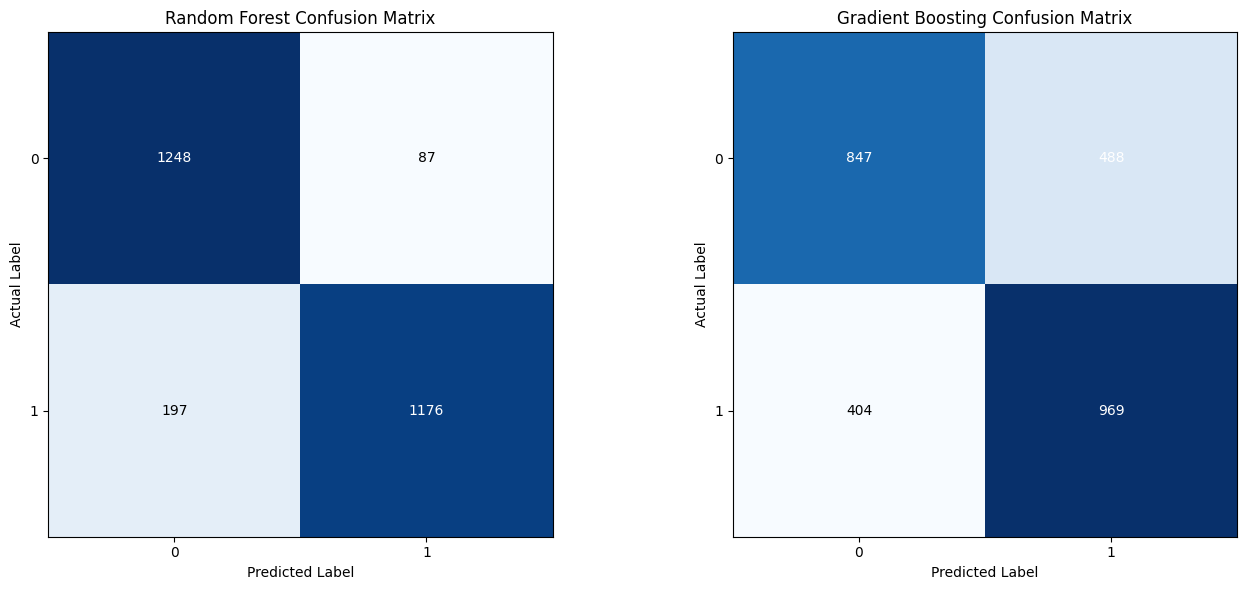

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(ax, cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Plots a confusion matrix on the given Axes.
    
    Parameters:
    - ax: matplotlib Axes object to draw the plot on.
    - cm: 2D array (confusion matrix values)
    - classes: List of class labels for the axes
    - title: Title for the plot
    - cmap: Colormap to use for the plot
    """
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    
    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    ax.set_ylabel('Actual Label')
    ax.set_xlabel('Predicted Label')
    return im

# Define confusion matrix values for the two models
confusion_matrices = {
    "Logistic Regression": np.array([[757 578]
                               [722 651]]),
    "Linear SVC": np.array([[847, 488],
                                   [404, 969]])
}

classes = ['0', '1']

# Create a 1x2 grid for the subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, (model_name, cm) in zip(axes, confusion_matrices.items()):
    plot_confusion_matrix(ax, cm, classes, title=f"{model_name} Confusion Matrix")

plt.tight_layout()
plt.show()


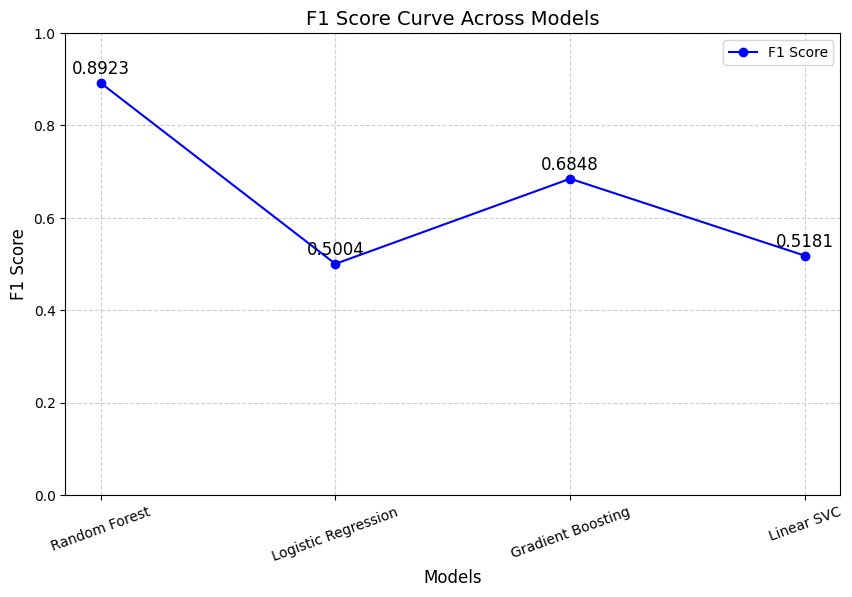

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ["Random Forest", "Logistic Regression", "Gradient Boosting", "Linear SVC"]

# F1 Scores
f1_scores = [0.8923, 0.5004, 0.6848, 0.5181]

# X-axis values (indexing models)
x = np.arange(len(models))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, f1_scores, marker='o', linestyle='-', color='b', label='F1 Score')
plt.ylim(0, 1)
plt.xlabel("Models", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.title("F1 Score Curve Across Models", fontsize=14)
plt.xticks(x, models, rotation=20)
plt.grid(True, linestyle='--', alpha=0.6)

# Annotate points
for i, score in enumerate(f1_scores):
    plt.text(i, score + 0.02, f"{score:.4f}", ha='center', fontsize=12)

plt.legend()
plt.show()


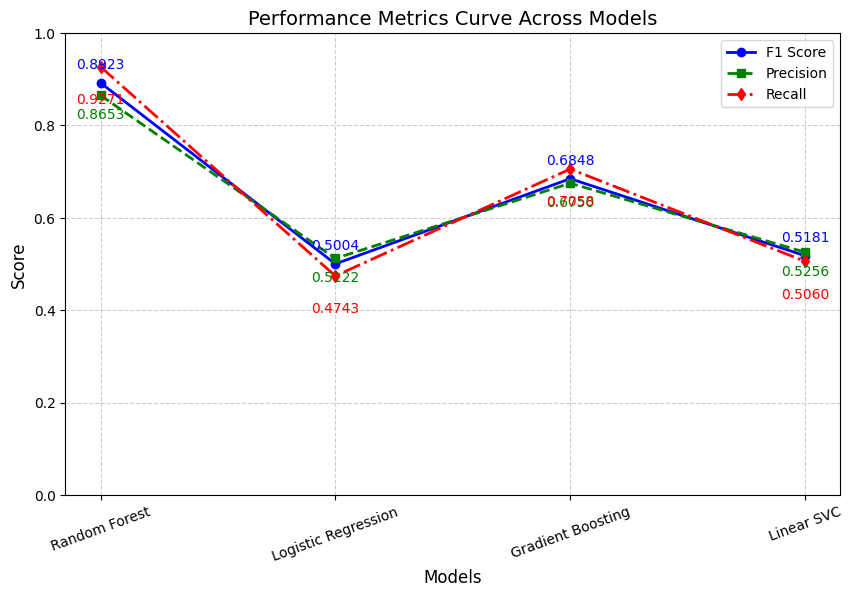

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ["Random Forest", "Logistic Regression", "Gradient Boosting", "Linear SVC"]

# Metrics
f1_scores = [0.8923, 0.5004, 0.6848, 0.5181]
precision_scores = [0.8653, 0.5122, 0.6750, 0.5256]
recall_scores = [0.9271, 0.4743, 0.7058, 0.5060]

# X-axis values (indexing models)
x = np.arange(len(models))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, f1_scores, marker='o', linestyle='-', color='b', label='F1 Score', linewidth=2)
plt.plot(x, precision_scores, marker='s', linestyle='--', color='g', label='Precision', linewidth=2)
plt.plot(x, recall_scores, marker='d', linestyle='-.', color='r', label='Recall', linewidth=2)
plt.ylim(0, 1)
plt.xlabel("Models", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Performance Metrics Curve Across Models", fontsize=14)
plt.xticks(x, models, rotation=20)
plt.grid(True, linestyle='--', alpha=0.6)

# Annotate points with slight vertical spacing
for i, (f1, prec, rec) in enumerate(zip(f1_scores, precision_scores, recall_scores)):
    plt.text(i, f1 + 0.03, f"{f1:.4f}", ha='center', fontsize=10, color='b')
    plt.text(i, prec - 0.05, f"{prec:.4f}", ha='center', fontsize=10, color='g')
    plt.text(i, rec - 0.08, f"{rec:.4f}", ha='center', fontsize=10, color='r')

plt.legend()
plt.show()
